In [2]:
from datetime import datetime
import matplotlib.pylab as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import stor
import sys
from scipy import stats

In [3]:
# For each sequencer, read in basic_stats_human files and manifests and combine
df_iseq = pd.read_csv("/Users/rchin/Documents/IPS primer evaluation/iSeq v HiSeq/unique sample 5.19/batch_basic_stats.basic_stats_human_iseq_unique.csv") #iseq basic_stats
df_ibc = pd.read_csv("/Users/rchin/Documents/IPS primer evaluation/iSeq v HiSeq/unique sample 5.19/BPC29602-1614.manifest_clean 5.23.csv") #iseq sample manifest
df_hiseq= pd.read_csv("/Users/rchin/Documents/IPS primer evaluation/iSeq v HiSeq/unique sample 5.19/batch_basic_stats.basic_stats_human_hiseq_unique.csv") #hiseq basic_stats
df_hbc = pd.read_csv("/Users/rchin/Documents/IPS primer evaluation/iSeq v HiSeq/unique sample 5.19/H5M3TBBXY.manifest_clean 5.28.csv") #hiseq sample manifest

# Merge iSeq samplesheet with iSeq qc metrics
df_icombine = pd.merge(df_ibc, df_iseq, on="sample")
# Fix typo in loc[141] from 'IPS_XY_Pooled_IPS_CLN_RCSET_D10' to 'IPS_XY_Pooled_IPS_CLN_RCSET2_D10'
# df_icombine.at[141,'sample'] = 'IPS_XY_Pooled_IPS_CLN_RCSET2_D10'

# Merge hiseq samplesheet with hiseq qc metrics
df_hcombine = pd.merge(df_hbc, df_hiseq, on="sample")

# consolidate sample sheet to one lane
df_hcombine1 = df_hcombine[df_hcombine['lane'] == 1]

# merge iSeq and HiSeq QC Metrics/samplesheet
df_merge = pd.merge(df_hcombine1,df_icombine, on="sample", suffixes=('_hiseq', '_iseq'), how='outer', indicator=True)

#rename unique_id to plate_coor
df_merge=df_merge.rename(columns = {'unique_id_x_hiseq':'plate_coor'})

# display(df_merge.head())
# df_merge.columns

In [4]:
# read in all_barcodes.html files for iSeq/HiSeq
df_all_bc_iseq = pd.read_csv('/Users/rchin/Documents/IPS primer evaluation/iSeq v HiSeq/unique sample 5.19/unique_iseq_all_barcodes.html.csv')
df_all_bc_hiseq = pd.read_csv('/Users/rchin/Documents/IPS primer evaluation/iSeq v HiSeq/unique sample 5.19/unique_hiseq_all_barcodes.html.csv')

#rename columns to simpler names
'''correct column names:
barcode, hiseq_avg_pct_perfect_bc, hiseq_avg_pct_one_mismatch_bc, 
iseq_avg_pct_perfect_bc, iseq_avg_pct_one_mismatch_bc'''

df_all_bc_iseq.rename(index=str, columns={'Barcode sequence': 'barcode_iseq', 
                                          '% Perfect\nbarcode': 'iseq_avg_pct_perfect_bc',
                                          '% One mismatch\nbarcode': 'iseq_avg_pct_one_mismatch_bc'}, inplace = True)

df_all_bc_hiseq.rename(index=str, columns={'Barcode sequence': 'barcode_hiseq',
                                           '% Perfect\nbarcode': 'hiseq_pct_perfect_bc',
                                           '% One mismatch\nbarcode': 'hiseq_pct_one_mismatch_bc'}, inplace=True)


#convert pct columns to proper decimal format (need to change column names first)
df_all_bc_iseq.iseq_avg_pct_perfect_bc /= 100
df_all_bc_hiseq.hiseq_pct_perfect_bc /= 100
df_all_bc_hiseq.hiseq_pct_one_mismatch_bc /= 100
# display (df_all_bc_hiseq.head())

In [5]:
''' from hiseq all_barcode.html calculate average of pct_perfect_barcode and one_mismatch_barcode'''
''' not the most accuracte way to combine lanes, which would be to take number of 'PF clusters' into consideration,
    but average is very close as long as no individual lanes fail'''
# dftest = df_all_bc_hiseq.copy()

df_perfect_mean = df_all_bc_hiseq.groupby('barcode_hiseq',as_index=False)['hiseq_pct_perfect_bc'].mean().rename(columns = {'hiseq_pct_perfect_bc':'hiseq_avg_pct_perfect_bc'})
df_mismatch_mean = df_all_bc_hiseq.groupby('barcode_hiseq', as_index=False)['hiseq_pct_one_mismatch_bc'].mean().rename(columns = {'hiseq_pct_one_mismatch_bc':'hiseq_avg_pct_one_mismatch_bc'})

# display(df_perfect_mean.head())
df_all_bc_hiseq = df_all_bc_hiseq.merge(df_perfect_mean, on='barcode_hiseq')
df_all_bc_hiseq = df_all_bc_hiseq.merge(df_mismatch_mean, on='barcode_hiseq')
df_all_bc_hiseq = df_all_bc_hiseq[df_all_bc_hiseq.Lane == 1]
# display(df_all_bc_hiseq.head(10))


In [6]:
# Collect linear regression statistics:
slope, intercept, r_value, p_value, std_err =\
    stats.linregress(df_merge.total_mapped_reads_iseq, df_merge.total_mapped_reads_hiseq)
print ('trendline:', slope,'x +', intercept)
print ('r-squared:',r_value**2)

# Calculate Cv for iSeq and HiSeq mapped reads
cv_i = stats.variation(df_merge.total_mapped_reads_iseq)
cv_h = stats.variation(df_merge.total_mapped_reads_hiseq)
print ("iseqCV =", cv_i, "hiseqCV =", cv_h)

trendline: 419.76111147169587 x + 349800.2056319411
r-squared: 0.8941789568672946
iseqCV = 0.1737278254841405 hiseqCV = 0.16166348612329426


In [7]:
# Function to calculate residual
def y_distance(x1, y1, a, c):
    y_d = y1 - (a * x1 + c)
    return y_d

In [8]:
# To add column for residual values (y-axis distance from point to trendline) using linregress slope/intercept
residual_series = pd.Series()
for i, row in df_merge.iterrows():
    residual = pd.Series([y_distance(row.total_mapped_reads_iseq, row.total_mapped_reads_hiseq, slope, intercept)])
    residual_series = residual_series.append(residual, ignore_index=True)

In [9]:
#add residual and percent residual(percent change required to get point to trend line.)
df_merge['residual'] = residual_series  #residual is y-distance
df_merge['abs_residual'] = abs(df_merge['residual'])
# df_merge['cv_residual'] = stats.variation(df_merge.residual)
df_merge['pct_residual'] = (residual_series / df_merge.total_mapped_reads_hiseq * -1)
df_merge['abs_pct_residual'] = abs(df_merge['pct_residual'])

# Sort by abs_pct_residual, high-to-low
df_merge = df_merge.sort_values(by=['abs_pct_residual'], ascending=False)
# display (df_merge.head())

In [10]:
'''Add avg_pct_perfect_bc from hiseq and iseq to df_merge and export'''
# df_merge_bc = df_merge.merge(df_all_bc_hiseq[['barcode','hiseq_avg_pct_perfect_bc','hiseq_avg_pct_one_mismatch_bc']],
#          left_on='barcode_hiseq', right_on='barcode').merge(df_all_bc_iseq[['iseq_correct_barcode','iseq_avg_pct_perfect_bc','iseq_avg_pct_one_mismatch_bc']],
#          left_on='barcode_hiseq', right_on='iseq_correct_barcode')
# ^fix this for rev-comp barcode for iseq
df_merge_bc = df_merge.merge(df_all_bc_hiseq[['barcode_hiseq','hiseq_avg_pct_perfect_bc','hiseq_avg_pct_one_mismatch_bc']],
         left_on='barcode_hiseq', right_on='barcode_hiseq').merge(df_all_bc_iseq[['barcode_iseq','iseq_avg_pct_perfect_bc','iseq_avg_pct_one_mismatch_bc']],
         left_on='barcode_iseq', right_on='barcode_iseq')
# display (df_merge_bc.head())
# print (df_merge_bc.columns)

# display (df_merge_bc.head())
bc_summary = ['barcode_hiseq', 'plate_coor', 'residual', 'abs_residual', 'pct_residual', 
           'abs_pct_residual', 'hiseq_avg_pct_perfect_bc', 'hiseq_avg_pct_one_mismatch_bc','iseq_avg_pct_perfect_bc',
             'iseq_avg_pct_one_mismatch_bc']
df_merge_bc_summary = df_merge_bc[bc_summary]

display(df_merge_bc_summary.tail(20))

#save files
# df_merge_bc.to_csv("/Users/rchin/Downloads/iseq_hiseq_bc_unique_5.30.csv")
# df_merge_bc_summary.to_csv("/Users/rchin/Downloads/iseq_hiseq_bc_unique_summary_5.30.csv")


,barcode_hiseq,plate_coor,residual,abs_residual,pct_residual,abs_pct_residual,hiseq_avg_pct_perfect_bc,hiseq_avg_pct_one_mismatch_bc,iseq_avg_pct_perfect_bc,iseq_avg_pct_one_mismatch_bc
648,TTATCTGA,IPS_primerSet2_H06,3917.163998,3917.163998,-0.001162,0.001162,0.946287,0.053712,1.0,NaN
649,AACGTTCT,IPS_primerSet1_A10,3988.563881,3988.563881,-0.001137,0.001137,0.963938,0.036062,1.0,NaN
650,CGCAGCCA,IPS_primerSet5_C11,-3591.630302,3591.630302,0.001124,0.001124,0.951675,0.048325,1.0,NaN
651,CGCGACCT,IPS_primerSet2_D04,-3444.496899,3444.496899,0.001106,0.001106,0.968812,0.031188,1.0,NaN
652,CATGCCGT,IPS_primerSet3_C08,2199.470237,2199.470237,-0.000854,0.000854,0.963487,0.036512,1.0,NaN
653,ACTTCCGG,IPS_primerSet3_A12,-1864.457271,1864.457271,0.000827,0.000827,0.954975,0.045025,1.0,NaN
654,AGGACTGA,IPS_primerSet4_A05,2229.436789,2229.436789,-0.000823,0.000823,0.945300,0.054700,1.0,NaN
655,TCCTACCA,IPS_primerSet7_G09,-1955.446727,1955.446727,0.000671,0.000671,0.955937,0.044062,1.0,NaN
656,TATGATCC,IPS_primerSet5_H02,2060.841814,2060.841814,-0.000620,0.000620,0.956025,0.043975,1.0,NaN
657,GTATTATA,IPS_primerSet1_F06,1724.586721,1724.586721,-0.000619,0.000619,0.951825,0.048175,1.0,NaN


In [11]:
def linregress_all_metrics(df, x, metrics):
#     slope, intercept, r_value, p_value, std_err =\
#     stats.linregress(df_merge.total_mapped_reads_iseq, df_merge.total_mapped_reads_hiseq)
# print ('trendline:', slope,'x +', intercept)
# print ('r-squared:',r_value**2)

    df_stats = pd.DataFrame()
    statistics = ['slope', 'intercept', 'r_value', 'p_value', 'std_err']

    for metric in metrics:
        test = x
        ref = metric
        df_tmp = pd.DataFrame(columns=statistics)
        series_stat = pd.Series(stats.linregress(df[ref], df[test]), index=statistics)
        df_tmp = df_tmp.append(series_stat, ignore_index=True)
        df_tmp['comparison'] = x
        df_tmp['metric'] = metric
        df_tmp['r_squared'] = df_tmp.r_value**2

        df_stats = pd.concat([df_tmp, df_stats])

    df_stats = df_stats.reset_index(drop=True)
    return df_stats


In [12]:
#Generate table to perform linear regression analysis of one metric against a series of metrics.

comparison = 'pct_residual'
metrics_shortlist = ['total_mapped_reads_pre_dedupe_hiseq', 'total_mapped_reads_hiseq',
                     'total_unmapped_reads_hiseq', 'duped_reads_hiseq', 'ILMN_adapters_hiseq',
                     'library_complexity_hiseq','reads_aligned_at_duped_pos_hiseq', 'proximal_dup_rate_hiseq',
                     'max_contamination_hiseq']

all_hiseq = ['total_mapped_reads_pre_dedupe_hiseq', 'total_mapped_reads_hiseq',
       'total_unmapped_reads_hiseq', 'ILMN_adapters_hiseq',
       'duped_reads_hiseq', 'mapped_freq_hiseq', 'unmapped_freq_hiseq',
       'library_complexity_hiseq', 'Q30_hiseq', 'Q20_hiseq',
       'contamination_hiseq', 'reads_aligned_at_duped_pos_hiseq',
       'proximal_dup_reads_hiseq', 'proximal_dup_rate_hiseq',
       'max_contamination_hiseq', 'total_contamination_hiseq', 'hiseq_avg_pct_perfect_bc']

all_iseq = ['total_mapped_reads_pre_dedupe_iseq', 'total_mapped_reads_iseq',
       'total_unmapped_reads_iseq', 'ILMN_adapters_iseq', 'duped_reads_iseq',
       'mapped_freq_iseq', 'unmapped_freq_iseq', 'library_complexity_iseq',
       'Q30_iseq', 'Q20_iseq', 'contamination_iseq',
       'reads_aligned_at_duped_pos_iseq', 'proximal_dup_reads_iseq',
       'proximal_dup_rate_iseq', 'max_contamination_iseq',
       'total_contamination_iseq']

# Collect regression stats of top-## abs_pct_residual and analyze correllation with metrics.
# df_stats = linregress_all_metrics(df_merge.sort_values(by=['abs_pct_residual'], ascending=False).head(8),
#                                   comparison, all_hiseq)
# print (df_stats.sort_values(by=['r_squared'], ascending=False))

# Create subset of samples with high abs_pct_residual values to analyze correllation.
df_deviate = df_merge_bc[df_merge_bc['abs_pct_residual'] > 0.125]
#  print(len(df_deviate['hiseq_avg_pct_perfect_bc']))
df_stats1 = linregress_all_metrics(df_deviate, comparison, all_hiseq)
display(df_stats1.sort_values(by=['r_squared'], ascending=False))
print('n = ', len(df_deviate))



,slope,intercept,r_value,p_value,std_err,comparison,metric,r_squared
12,-2.348147e-06,1.058442,-0.888325,0.000010,3.366642e-07,pct_residual,duped_reads_hiseq,0.789122
4,-3.889477e-06,0.945507,-0.869493,0.000025,6.128206e-07,pct_residual,proximal_dup_reads_hiseq,0.756017
9,1.579546e+01,-13.612881,0.854931,0.000049,2.658158e+00,pct_residual,library_complexity_hiseq,0.730907
0,-2.022683e+00,1.988073,-0.831654,0.000121,3.745731e-01,pct_residual,hiseq_avg_pct_perfect_bc,0.691648
16,-3.769903e-07,1.283050,-0.813325,0.000226,7.479540e-08,pct_residual,total_mapped_reads_pre_dedupe_hiseq,0.661498
15,-4.370086e-07,1.295658,-0.787369,0.000493,9.489889e-08,pct_residual,total_mapped_reads_hiseq,0.619949
5,-8.695817e-07,0.989586,-0.784050,0.000541,1.909301e-07,pct_residual,reads_aligned_at_duped_pos_hiseq,0.614735
3,-1.712956e+01,1.327154,-0.703360,0.003438,4.801363e+00,pct_residual,proximal_dup_rate_hiseq,0.494716
8,2.920751e+01,-28.299286,0.697556,0.003839,8.321063e+00,pct_residual,Q30_hiseq,0.486584
7,8.116368e+01,-80.227125,0.677615,0.005508,2.443096e+01,pct_residual,Q20_hiseq,0.459162


n =  15


In [13]:
# calculate r-squared values for the top-# of highest 'abs_pct_residual' values
stat_range = [10, 700]

# print (df_stats1[['metric','r_squared']].sort_values(by=['r_squared'], ascending=False))
df_stats2 = linregress_all_metrics(df_merge_bc.sort_values(by=['abs_pct_residual'], ascending=False).head(stat_range[0]),
                                   comparison, all_hiseq)
# df_stats2 = df_stats2.rename(columns = {'r_squared':'r_squared2'})
df_stats3 = linregress_all_metrics(df_merge_bc.sort_values(by=['abs_pct_residual'], ascending=False).head(stat_range[1]),
                                   comparison, all_hiseq)

# df_stats_merge = pd.concat([df_stats2, df_stats3], keys=['metric'])
df_stats2['num'] = stat_range[0]
df_stats3['num'] = stat_range[1]
suffix = ['_top_'+ str(stat_range[0]),'_top_' + str(stat_range[1])]
df_stats_merge = df_stats2.merge(df_stats3, on='metric', suffixes=suffix)
# display(df_stats2)
df_stats_merge1 = df_stats_merge.reindex(sorted(df_stats_merge.columns), axis=1).sort_values(by=['r_squared'+suffix[0]], ascending=False).set_index('metric')
display (df_stats_merge1)
print (suffix[1], 'samples, r-squared hiseq_avg_pct_perfect_bc: ', df_stats_merge1['r_squared'+suffix[1]].loc['hiseq_avg_pct_perfect_bc'])


,comparison_top_10,comparison_top_700,intercept_top_10,intercept_top_700,num_top_10,num_top_700,p_value_top_10,p_value_top_700,r_squared_top_10,r_squared_top_700,r_value_top_10,r_value_top_700,slope_top_10,slope_top_700,std_err_top_10,std_err_top_700
metric,,,,,,,,,,,,,,,,
proximal_dup_reads_hiseq,pct_residual,pct_residual,1.183936,0.152814,10,700,0.000058,1.123501e-31,0.880682,0.186223,-0.938447,-0.431535,-5.074788e-06,-6.575602e-07,6.604143e-07,5.326413e-08
duped_reads_hiseq,pct_residual,pct_residual,1.183385,0.124595,10,700,0.000176,4.974412e-22,0.843355,0.130548,-0.918344,-0.361314,-2.634630e-06,-2.720904e-07,4.014468e-07,2.720910e-08
library_complexity_hiseq,pct_residual,pct_residual,-14.388806,-5.140479,10,700,0.001380,4.560538e-53,0.741147,0.297626,0.860899,0.545551,1.671861e+01,5.931683e+00,3.493249e+00,3.530936e-01
total_mapped_reads_pre_dedupe_hiseq,pct_residual,pct_residual,1.368797,0.111341,10,700,0.002265,5.481436e-14,0.708260,0.081462,-0.841582,-0.285415,-3.940858e-07,-3.230912e-08,8.942255e-08,4.203971e-09
hiseq_avg_pct_perfect_bc,pct_residual,pct_residual,1.839696,1.799971,10,700,0.002843,2.690113e-80,0.691898,0.417872,-0.831804,-0.646430,-1.816471e+00,-1.878211e+00,4.285582e-01,8.590032e-02
total_mapped_reads_hiseq,pct_residual,pct_residual,1.380373,0.107319,10,700,0.003709,1.104940e-12,0.671630,0.073281,-0.819530,-0.270705,-4.546887e-07,-3.589530e-08,1.124051e-07,4.946270e-09
reads_aligned_at_duped_pos_hiseq,pct_residual,pct_residual,0.983677,0.070864,10,700,0.007742,3.523437e-08,0.608891,0.044646,-0.780315,-0.211295,-7.999285e-07,-5.937184e-08,2.266652e-07,1.064230e-08
proximal_dup_rate_hiseq,pct_residual,pct_residual,1.640745,0.453991,10,700,0.019281,2.592456e-42,0.515983,0.243627,-0.718320,-0.493586,-2.127808e+01,-6.651579e+00,7.286177e+00,4.541429e-01
Q30_hiseq,pct_residual,pct_residual,-25.412545,-13.163337,10,700,0.050474,8.379604e-30,0.398036,0.175688,0.630901,0.419151,2.628056e+01,1.356645e+01,1.142651e+01,1.138687e+00


_top_700 samples, r-squared hiseq_avg_pct_perfect_bc:  0.41787201423368026


In [14]:
comparison = 'pct_residual'
def rsquared(df, x, metrics, limit):

    df_rsquared = pd.DataFrame()

    for num in range(2,limit):
        df_tmp = pd.DataFrame()
        df_tmp = linregress_all_metrics(df.sort_values(by=[x], ascending=False).head(num),
                                   x, metrics)
        df_tmp['num'] = num
        df_tmp[x] = df.sort_values(by=['abs_pct_residual'], ascending=False).reset_index().loc[num-2][x]
        df_rsquared = pd.concat([df_tmp, df_rsquared], sort=False)
    
    return df_rsquared

In [15]:
# m, b, r_value, p_value, stderr = stats.linregress(df_merge[comparison], df_merge['max_contamination_hiseq'])
statistics = ['slope', 'intercept', 'r_value', 'p_value', 'std_err']
series_stat = pd.Series(stats.linregress(df_merge_bc[comparison], df_merge_bc['max_contamination_hiseq']), index=statistics)
print ('r-value max contamination: ', series_stat['r_value']**2)
     


r-value max contamination:  0.002586505638510879


In [16]:
# df_stats[df_stats.metric == 'total_contamination_hiseq'].r_squared
# df_stats.set_index(df_stats['metric']).transpose().loc['r_squared']
df_rsquared = rsquared(df_merge_bc, comparison, all_hiseq,26)
# df_rsquared['num'] = df_rsquared.index
# df_rsquared
sub = ['max_contamination_hiseq','ILMN_adapters_hiseq', 'library_complexity_hiseq','total_contamination_hiseq', 'Q30_hiseq']
df_rsq_sub = df_rsquared.loc[df_rsquared['metric'].isin(sub)]


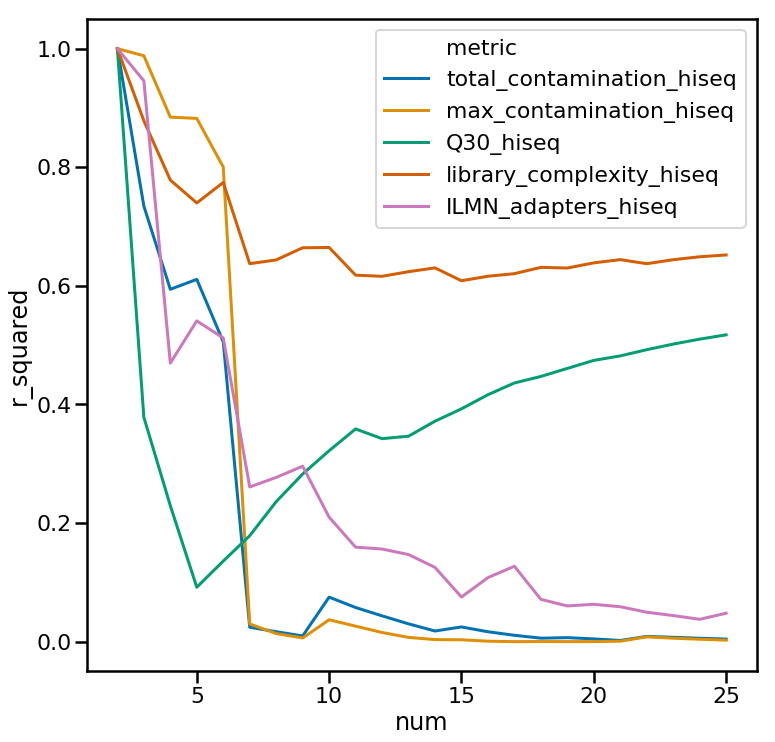

In [17]:
# Plot lineplot  with TOP-2 residuals omitted with hue for primer set
plt.figure(figsize=(12, 12))
sns.set_context("poster")
sns.lineplot(x='num', y="r_squared", hue='metric', 
             data=df_rsq_sub, palette='colorblind')
# sns.lineplot(x='num', y='abs_pct_residual', data=df_rsq_sub, palette='dark')

In [18]:
# create a pandas series to compare two qc metrics
# m, b, r_value, p_value, stderr = stats.linregress(df_merge_bc_summary[comparison],
                                # df_merge_bc_summary['hiseq_avg_pct_perfect_bc']))
statistics = ['slope', 'intercept', 'r_value', 'p_value', 'std_err']
series_stat = pd.Series(stats.linregress(df_merge_bc['library_complexity_hiseq'].head(25), 
                                         df_merge_bc['hiseq_avg_pct_perfect_bc'].head(25)), index=statistics)
print ('r-squared:', series_stat['r_value']**2)

r-squared: 0.5545913901042062


In [19]:
'''Plot r_squared correlation between abs_pct_residual and hiseq_avg_pct_perfect_bc'''
df_bc_rsqd = rsquared(df_merge_bc_summary, comparison, ['hiseq_avg_pct_perfect_bc'], 500)#len(df_merge_bc_summary))
# Plot lineplot with r-squared values vs number of samples included in correlation analysis
ax = plt.figure(figsize=(12, 12))
sns.set_context("poster")
# ax = sns.lineplot(x='num', y="r_squared", data=df_bc_rsqd, palette='colorblind')

# ax.set_title('High Correlation Between Abs. Residual% and Barcode Read Accuracy')





<Figure size 864x864 with 0 Axes>

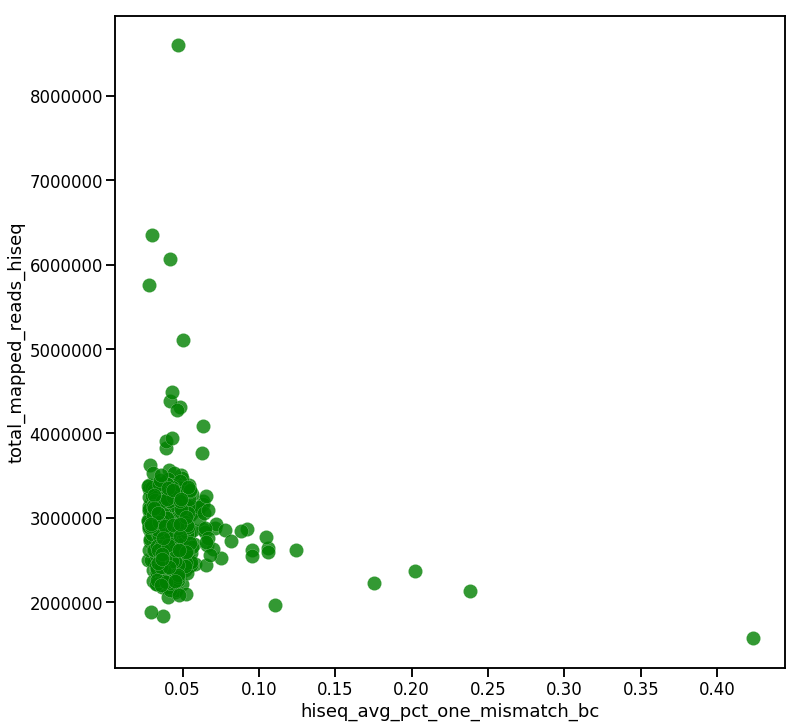

In [20]:
plt.figure(figsize=(12, 12))
sns.set_context("talk")

# ax = sns.scatterplot(x=df_merge_bc.hiseq_avg_pct_perfect_bc*100,
#                      y=df_merge_bc.abs_pct_residual*100, alpha=0.8, linewidth=0.2, color='teal',
#              data=df_merge_bc.sort_values(by='hiseq_avg_pct_perfect_bc', ascending=True).tail(631))

# ax.set_title('Variation of Abs. %Residual in 95th-Percentile Performing Barcodes')
# ax.set_xlabel('Average Percent Perfect Barcode')
# ax.set_ylabel('Absolute Percent Residual')

ax = sns.scatterplot(x=df_merge_bc.hiseq_avg_pct_one_mismatch_bc, y=df_merge_bc.total_mapped_reads_hiseq,
                     alpha=0.8, linewidth=0.2, color='green', s=200,
                     data=df_merge_bc.sort_values(by='hiseq_avg_pct_one_mismatch_bc', ascending=False))

plt.show()

# ax.figure.savefig("/Users/rchin/Downloads/Barcode_v_mapped_4.29.png", bbox_inches = 'tight')


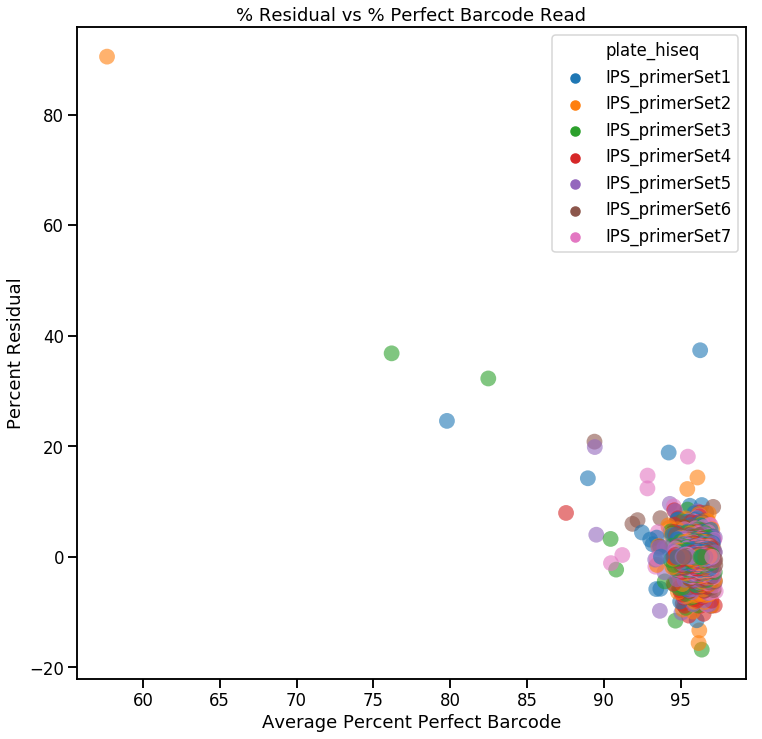

In [21]:
'''scatter plot of avg percent perfect barcode vs absolute percent residual'''
plate_list=['IPS_primerSet1', 'IPS_primerSet2', 'IPS_primerSet3', 'IPS_primerSet4', 'IPS_primerSet5',
           'IPS_primerSet6', 'IPS_primerSet7']

plt.figure(figsize=(12, 12))
sns.set_context("talk")

ax = sns.scatterplot(x=df_merge_bc.hiseq_avg_pct_perfect_bc*100, s=250, 
                     y=df_merge_bc.pct_residual*100, alpha=0.6, linewidth=0, #color='teal',
             data=df_merge_bc.sort_values(by='hiseq_avg_pct_perfect_bc', ascending=True), 
                     hue='plate_hiseq',hue_order=plate_list)

ax.set_title('% Residual vs % Perfect Barcode Read')
ax.set_xlabel('Average Percent Perfect Barcode')
ax.set_ylabel('Percent Residual')

plt.show()

# ax.figure.savefig("/Users/rchin/Downloads/pctResidual_v_PerfectBC_unique_5.30.png", bbox_inches = 'tight')

In [22]:
# print ('Abs Pct Residual CV =', stats.variation(df_merge_bc_summary.sort_values(by='hiseq_avg_pct_perfect_bc', ascending=True).tail(500).abs_pct_residual))
print ('Abs Pct Residual CV =', stats.variation(df_merge_bc_summary.tail(655).residual))
print ('Avg Pct Perfect Barcode CV = ', stats.variation(df_merge_bc_summary.hiseq_avg_pct_perfect_bc))


Abs Pct Residual CV = 12.817367902948591
Avg Pct Perfect Barcode CV =  0.022464841464135375


Text(0, 0.5, 'Percent Perfect Barcode')

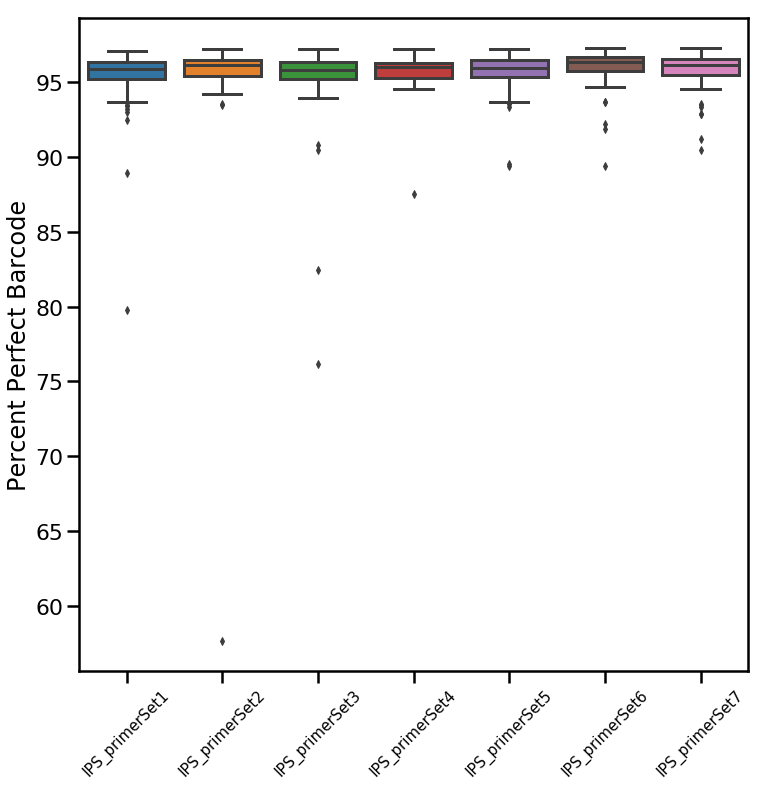

In [23]:
'''Box plot: Percent Perfect Barcode'''
df_merge_bc['plate_hiseq'] = df_merge_bc['plate_hiseq'].str.replace('IPS_CLN_RCSET','IPS_indexSet_').str.replace('a','').str.replace('b','')

plt.figure(figsize=(12, 12))
sns.set_context("poster")
ax = sns.boxplot(x='plate_hiseq', y=df_merge_bc.hiseq_avg_pct_perfect_bc*100, data=df_merge_bc.sort_values(by='plate_hiseq'))
loc, labels = plt.xticks()
ax.set_xticklabels(labels, rotation=45, fontsize=15)
ax.set_xlabel('')
ax.set_ylabel('Percent Perfect Barcode')

# ax.figure.savefig("/Users/rchin/Downloads/PerfectBC_box_unique_5.30.png", bbox_inches = 'tight')


Text(0, 0.5, '% Residual')

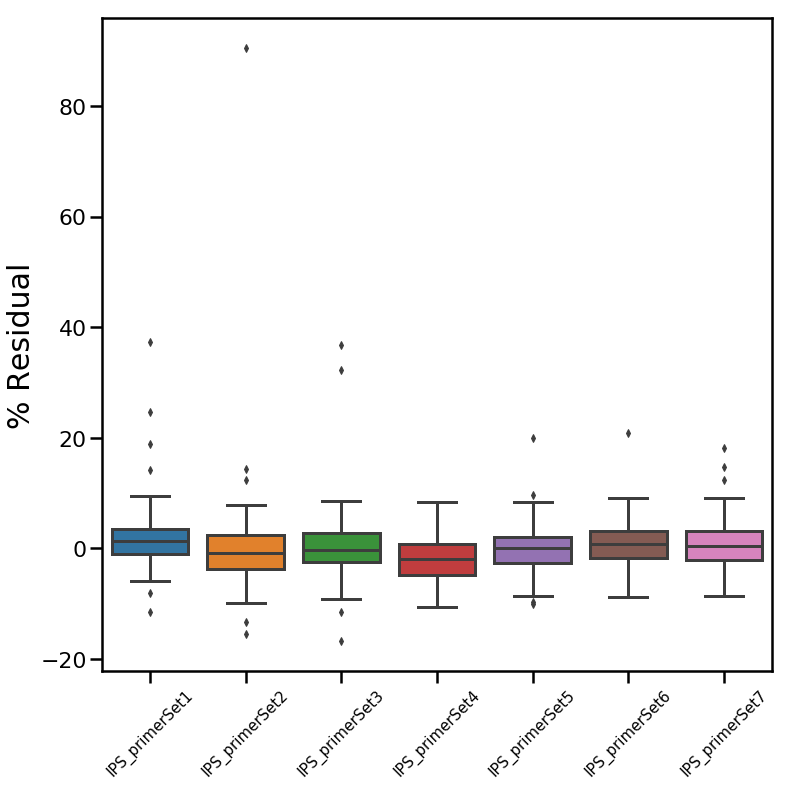

In [24]:
'''Box plot: Percent Residual'''
df_merge_bc['plate_hiseq'] = df_merge_bc['plate_hiseq'].str.replace('IPS_CLN_RCSET','IPS_indexSet_').str.replace('a','').str.replace('b','')

plt.figure(figsize=(12, 12))
sns.set_context("poster")
ax = sns.boxplot(x='plate_hiseq', y=df_merge_bc.pct_residual*100, data=df_merge_bc.sort_values(by='plate_hiseq'))
loc, labels = plt.xticks()
ax.set_xticklabels(labels, rotation=45, fontsize=15)
ax.set_xlabel('')
ax.set_ylabel('% Residual',fontsize=30)

# ax.figure.savefig("/Users/rchin/Downloads/Residual_box_unique_5.30.png", bbox_inches = 'tight')
              

In [25]:
# Calculate number of barcodes that meet certain pct perfect barcode criteria
print(len(df_merge_bc_summary[df_merge_bc_summary.hiseq_avg_pct_perfect_bc > 0.9])/len(df_merge_bc_summary))
print (len(df_merge_bc_summary[df_merge_bc_summary.hiseq_avg_pct_perfect_bc > 0.9]))

0.9865269461077845
659


In [26]:
# correlation between 1 barcode mismatch and total_mapped_reads_iseq
display(linregress_all_metrics(df_merge_bc.sort_values(by='hiseq_avg_pct_one_mismatch_bc', ascending=False).head(10),
                               'hiseq_avg_pct_one_mismatch_bc',
                               ['total_mapped_reads_hiseq', 'total_mapped_reads_iseq']))

,slope,intercept,r_value,p_value,std_err,comparison,metric,r_squared
0,3.503455e-05,-0.042500,0.213132,0.554381,5.678157e-05,hiseq_avg_pct_one_mismatch_bc,total_mapped_reads_iseq,0.045425
1,-2.202199e-07,0.686874,-0.818715,0.003773,5.460614e-08,hiseq_avg_pct_one_mismatch_bc,total_mapped_reads_hiseq,0.670295


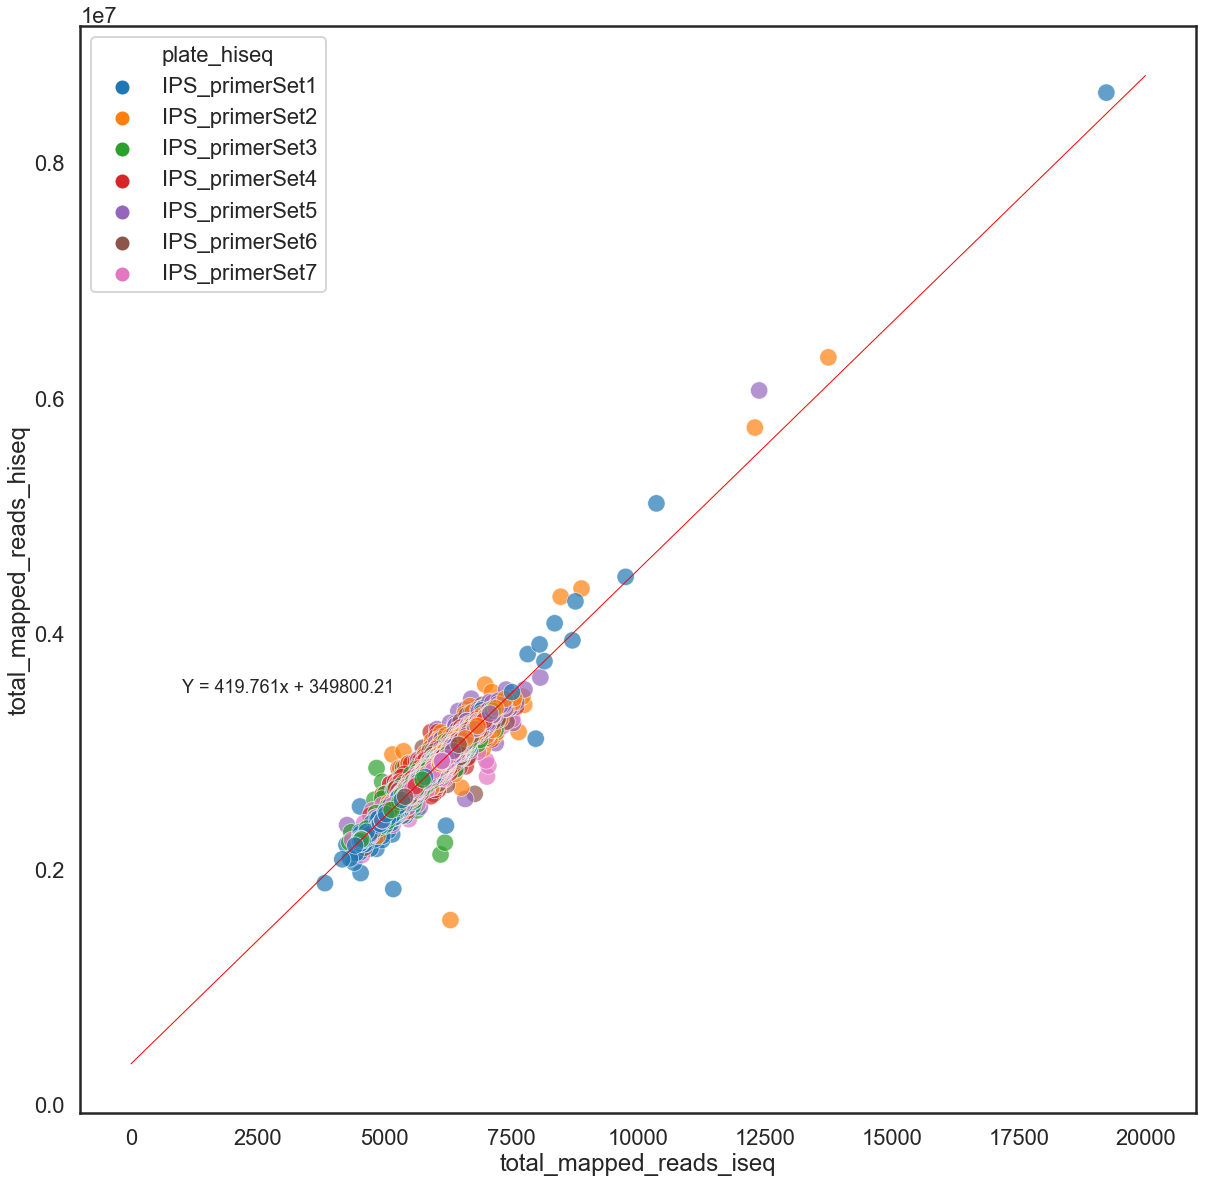

In [27]:
# Plot scatterplot with hue for primer set, same as in evaluation.ipynb
#replace plate_coor names with ips_index
# df_merge_bc['ips_plate'] = df_merge_bc['plate_hiseq'].str.replace('IPS_CLN_RCSET','IPS_indexSet_').str.replace('a','').str.replace('b','')
plate_list=['IPS_primerSet1', 'IPS_primerSet2', 'IPS_primerSet3', 'IPS_primerSet4', 'IPS_primerSet5',
           'IPS_primerSet6', 'IPS_primerSet7']

sns.set_style("white")
plt.figure(figsize=(20, 20))
sns.set_context("poster")
scat = sns.scatterplot(data=df_merge_bc, x='total_mapped_reads_iseq', y='total_mapped_reads_hiseq',
                       hue='plate_hiseq', alpha=.7, s=300, hue_order=plate_list)

line = slope * 20000 + intercept
plt.plot([0,20000],[intercept,line], 'r-', linewidth=1)

equation = 'Y = ' + str('{0:.6g}'.format(slope)) + 'x + ' + str('{0:.8g}'.format(intercept))
plt.text(1000,3500000,equation, label='trendline', fontsize=18)


plt.show()

#save figure
# figure = scat.get_figure()
# figure.savefig("/Users/rchin/Downloads/hiseq_iseq_scatter_4.30s.png", bbox_inches = 'tight')


In [28]:
# evaluate variance among samples with low abs pct residual (<5%)
df_lowresid = df_merge_bc[df_merge_bc['abs_pct_residual'] <= 0.05]
print (len(df_lowresid))

cv_m = stats.variation(df_lowresid.total_mapped_reads_hiseq)
cv_a = stats.variation(df_merge_bc.total_mapped_reads_hiseq)
print ("mapped_reads (<5% resid) CV =", cv_m, 'mapped_reads all CV = ', cv_a )

lr_mean = df_lowresid.total_mapped_reads_hiseq.mean()
lf_sd = df_lowresid.total_mapped_reads_hiseq.std()
print ('mean =', lr_mean, 'sd = ', lf_sd)

511
mapped_reads (<5% resid) CV = 0.1563343563116686 mapped_reads all CV =  0.16166348612329426
mean = 2917591.4168297458 sd =  456566.733392234


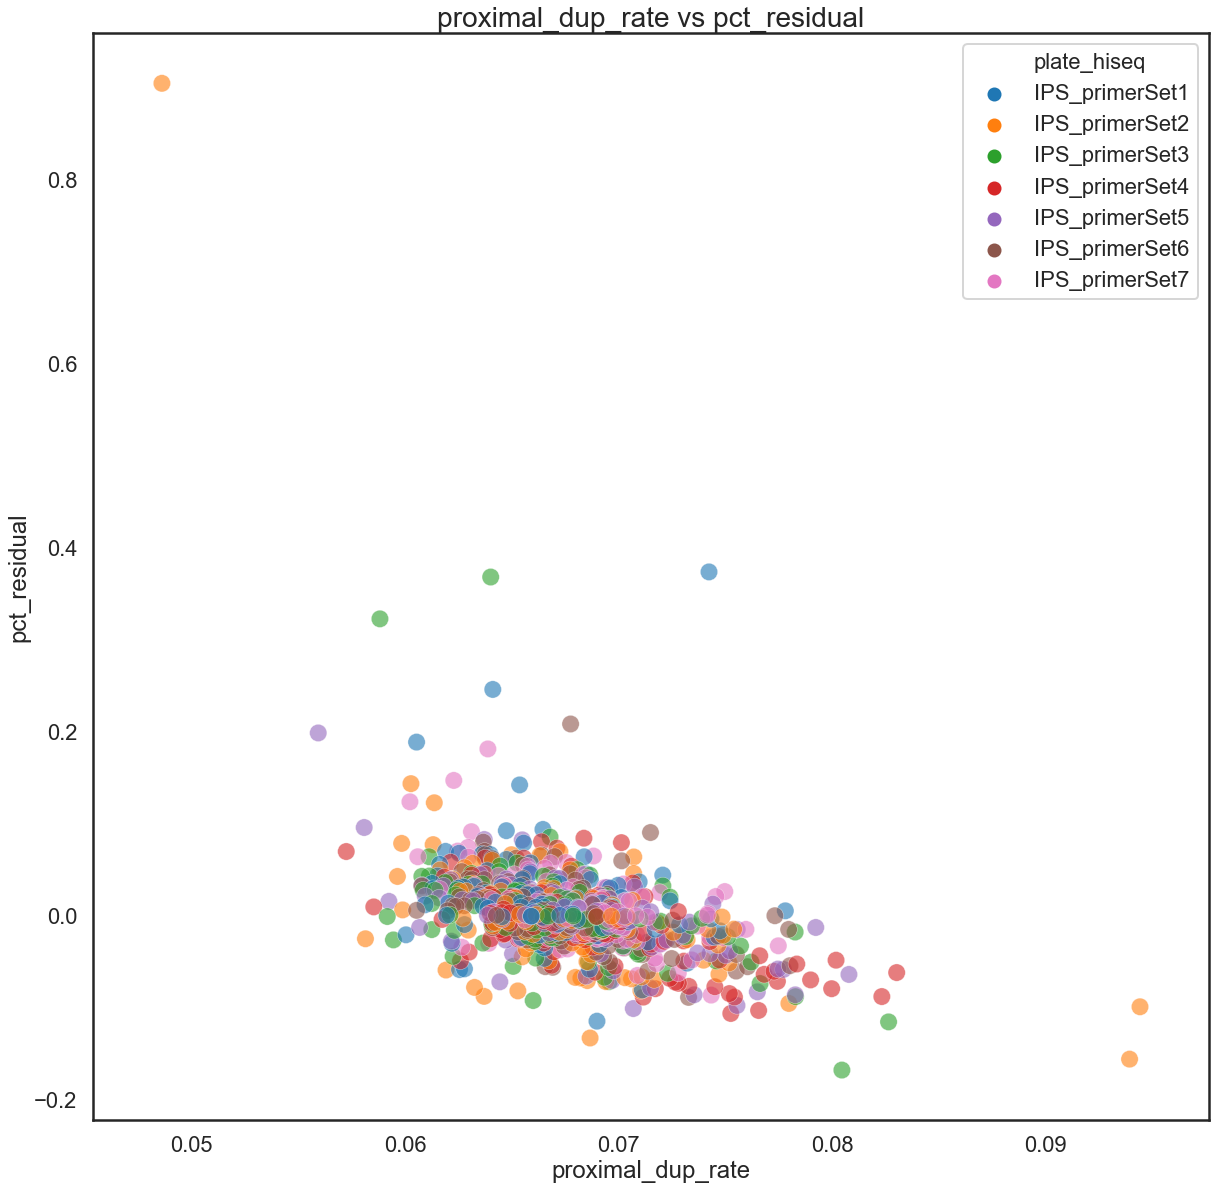

In [29]:
# scatter plot of <QC_metric>_hiseq (ie. total_mapped_reads_hiseq) vs library_complexity_hiseq

#Metrics: 'library_complexity', 'Q30', 'max_contamination', 'Q20', 'contamination',
# 'total_contamination', 'reads_aligned_at_duped_pos', 'proximal_dup_rate', 'unmapped_freq', 'mapped_freq'
metric = 'proximal_dup_rate'
y_metric = 'pct_residual'  #y_metrics: 'pct_residual', 'hiseq_avg_pct_perfect_bc'

plt.figure(figsize=(20, 20))
sns.set_context("poster")


scat = sns.scatterplot(data=df_merge_bc, x=metric+'_hiseq', y=y_metric, 
                       hue='plate_hiseq', alpha=0.6, linewidth=0.5, s=300, hue_order=plate_list)

scat.set_title('{} vs {}'.format(metric, y_metric), fontsize=28)
scat.set_xlabel(metric, fontsize=24)
scat.set_ylabel(y_metric, fontsize=24)

plt.show()

#save figure
# figure = scat.get_figure()
# figure.savefig("/Users/rchin/Downloads/hiseq_iseq_{}_5.30.png".format(metric), bbox_inches = 'tight')


In [30]:
#import bc_summary csvs
df_pool = pd.read_csv('/Users/rchin/Documents/IPS primer evaluation/iSeq v HiSeq/unique sample 5.19/iseq_hiseq_bc_summary_5.8 - for_comparison.csv')
df_unique = pd.read_csv('/Users/rchin/Documents/IPS primer evaluation/iSeq v HiSeq/unique sample 5.19/iseq_hiseq_bc_unique_summary_5.30 - for_confluence.csv')

# display(df_pool.head(10))
# display(df_unique.head(10))

df_compare = df_pool.merge(df_unique,left_on='barcode', right_on='barcode_hiseq', 
                           how='outer', suffixes=('_pool','_unique'))

display(df_compare.head(5))
# print (len(df_compare))
print (df_compare.columns)


,index_pool,barcode,plate_coor_pool,residual_pool,abs_residual_pool,pct_residual_pool,abs_pct_residual_pool,hiseq_avg_pct_perfect_bc_pool,hiseq_avg_pct_one_mismatch_bc_pool,iseq_avg_pct_perfect_bc_pool,...,barcode_hiseq,plate_coor_unique,residual_unique,abs_residual_unique,pct_residual_unique,abs_pct_residual_unique,hiseq_avg_pct_perfect_bc_unique,hiseq_avg_pct_one_mismatch_bc_unique,iseq_avg_pct_perfect_bc_unique,iseq_avg_pct_one_mismatch_bc_unique
0,0.0,AGAAGTCT,IPS_indexSet_2_B10,-1541255.30,1541255.30,0.9135,0.9135,0.5799,0.4201,1.0,...,AGAAGTCT,IPS_primerSet2_B10,-1422082,1422082,0.90499,0.90499,0.57662,0.42338,1.0,NaN
1,1.0,AGAATCGG,IPS_indexSet_3_B01,-912802.19,912802.19,0.4994,0.4994,0.7370,0.2630,1.0,...,AGAATCGG,IPS_primerSet3_B01,-783693,783693,0.36822,0.36822,0.76188,0.23813,1.0,NaN
2,2.0,AGATAGGC,IPS_indexSet_3_B05,-705757.11,705757.11,0.3750,0.3750,0.8051,0.1949,1.0,...,AGATAGGC,IPS_primerSet3_B05,-719376,719376,0.32277,0.32277,0.82479,0.17521,1.0,NaN
3,3.0,CCTCCGAG,IPS_indexSet_1_D02,-801684.94,801684.94,0.3638,0.3638,0.7727,0.2273,1.0,...,CCTCCGAG,IPS_primerSet1_D02,-583825,583825,0.24602,0.24602,0.79788,0.20213,1.0,NaN
4,4.0,CAGCCGGC,IPS_indexSet_1_C02,-768473.59,768473.59,0.2919,0.2919,0.9384,0.0616,1.0,...,CAGCCGGC,IPS_primerSet1_C02,-587385,587385,0.18874,0.18874,0.94221,0.05779,1.0,NaN


Index(['index_pool', 'barcode', 'plate_coor_pool', 'residual_pool',
       'abs_residual_pool', 'pct_residual_pool', 'abs_pct_residual_pool',
       'hiseq_avg_pct_perfect_bc_pool', 'hiseq_avg_pct_one_mismatch_bc_pool',
       'iseq_avg_pct_perfect_bc_pool', 'iseq_avg_pct_one_mismatch_bc_pool',
       'index_unique', 'barcode_hiseq', 'plate_coor_unique', 'residual_unique',
       'abs_residual_unique', 'pct_residual_unique', 'abs_pct_residual_unique',
       'hiseq_avg_pct_perfect_bc_unique',
       'hiseq_avg_pct_one_mismatch_bc_unique',
       'iseq_avg_pct_perfect_bc_unique',
       'iseq_avg_pct_one_mismatch_bc_unique'],
      dtype='object')


In [31]:
# add columns for average and difference between abs_pct_residual and hiseq_avg_pct_perfect_bc for pool and unique

df_compare['mean_pct_residual'] = df_compare[['pct_residual_pool','pct_residual_unique']].mean(axis=1)
df_compare['diff_pct_residual'] = df_compare['pct_residual_pool'] - df_compare['pct_residual_unique']
df_compare['mean_hiseq_avg_pct_perfect_bc'] = df_compare[['hiseq_avg_pct_perfect_bc_pool','hiseq_avg_pct_perfect_bc_unique']].mean(axis=1)
df_compare['diff_hiseq_avg_pct_perfect_bc'] = df_compare['hiseq_avg_pct_perfect_bc_pool'] - df_compare['hiseq_avg_pct_perfect_bc_unique']

display(df_compare.head(10))

#export comparison:

df_compare_export = df_compare[['index_pool', 'barcode', 'plate_coor_pool', 'pct_residual_pool',
                               'pct_residual_unique', 'mean_pct_residual', 'diff_pct_residual',
                               'hiseq_avg_pct_perfect_bc_pool','hiseq_avg_pct_perfect_bc_unique',
                               'mean_hiseq_avg_pct_perfect_bc', 'diff_hiseq_avg_pct_perfect_bc']]

# df_compare.to_csv('/Users/rchin/Downloads/pool_unique_compare 5.31.csv')
# df_compare_export.to_csv('/Users/rchin/Downloads/pool_unique_compare_summary 5.31.csv')


,index_pool,barcode,plate_coor_pool,residual_pool,abs_residual_pool,pct_residual_pool,abs_pct_residual_pool,hiseq_avg_pct_perfect_bc_pool,hiseq_avg_pct_one_mismatch_bc_pool,iseq_avg_pct_perfect_bc_pool,...,pct_residual_unique,abs_pct_residual_unique,hiseq_avg_pct_perfect_bc_unique,hiseq_avg_pct_one_mismatch_bc_unique,iseq_avg_pct_perfect_bc_unique,iseq_avg_pct_one_mismatch_bc_unique,mean_pct_residual,diff_pct_residual,mean_hiseq_avg_pct_perfect_bc,diff_hiseq_avg_pct_perfect_bc
0,0.0,AGAAGTCT,IPS_indexSet_2_B10,-1541255.30,1541255.30,0.9135,0.9135,0.5799,0.4201,1.0,...,0.90499,0.90499,0.57662,0.42338,1.0,NaN,0.909245,0.00851,0.578260,0.00328
1,1.0,AGAATCGG,IPS_indexSet_3_B01,-912802.19,912802.19,0.4994,0.4994,0.7370,0.2630,1.0,...,0.36822,0.36822,0.76188,0.23813,1.0,NaN,0.433810,0.13118,0.749440,-0.02488
2,2.0,AGATAGGC,IPS_indexSet_3_B05,-705757.11,705757.11,0.3750,0.3750,0.8051,0.1949,1.0,...,0.32277,0.32277,0.82479,0.17521,1.0,NaN,0.348885,0.05223,0.814945,-0.01969
3,3.0,CCTCCGAG,IPS_indexSet_1_D02,-801684.94,801684.94,0.3638,0.3638,0.7727,0.2273,1.0,...,0.24602,0.24602,0.79788,0.20213,1.0,NaN,0.304910,0.11778,0.785290,-0.02518
4,4.0,CAGCCGGC,IPS_indexSet_1_C02,-768473.59,768473.59,0.2919,0.2919,0.9384,0.0616,1.0,...,0.18874,0.18874,0.94221,0.05779,1.0,NaN,0.240320,0.10316,0.940305,-0.00381
5,5.0,TCCGCGCA,IPS_indexSet_5_H05,-603606.52,603606.52,0.2736,0.2736,0.8971,0.1029,1.0,...,0.19872,0.19872,0.89411,0.10589,1.0,NaN,0.236160,0.07488,0.895605,0.00299
6,6.0,CAATACCA,IPS_indexSet_6_A08,576343.68,576343.68,-0.2366,0.2366,0.9592,0.0408,1.0,...,0.01095,0.01095,0.96013,0.03988,1.0,NaN,-0.112825,-0.24755,0.959665,-0.00093
7,7.0,GAGATCTT,IPS_indexSet_6_D12,-656127.77,656127.77,0.2350,0.2350,0.8894,0.1106,1.0,...,0.20846,0.20846,0.89391,0.10609,1.0,NaN,0.221730,0.02654,0.891655,-0.00451
8,8.0,ACCGCCGA,IPS_indexSet_2_A11,363676.92,363676.92,-0.2092,0.2092,0.9582,0.0418,1.0,...,-0.06709,0.06709,0.96271,0.03729,1.0,NaN,-0.138145,-0.14211,0.960455,-0.00451
9,9.0,ATGGCGAG,IPS_indexSet_6_A05,444663.50,444663.50,-0.1831,0.1831,0.9539,0.0461,1.0,...,-0.01307,0.01307,0.95556,0.04444,1.0,NaN,-0.098085,-0.17003,0.954730,-0.00166


In [32]:
# Collect linear regression statistics on combined stats:
metric = 'pct_residual'
metric1 = 'hiseq_avg_pct_perfect_bc'

df_compare1 = df_compare.dropna(subset=['pct_residual_pool'])

r_slope, r_intercept, r_rvalue, r_pvalue, r_std_err =\
    stats.linregress(df_compare1[metric+'_pool'], df_compare1[metric+'_unique'])
print (metric,'trendline:', r_slope,'x +', r_intercept)
print (metric,'r-squared:',r_rvalue**2)


bc_slope, bc_intercept, bc_rvalue, bc_pvalue, bc_std_err =\
    stats.linregress(df_compare1[metric1+'_pool'], df_compare1[metric1+'_unique'])
print (metric1,'trendline:', bc_slope,'x +', bc_intercept)
print (metric1,'r-squared:',bc_rvalue**2)



pct_residual trendline: 0.6585465620729033 x + 0.0005103088640837513
pct_residual r-squared: 0.5347653811571895
hiseq_avg_pct_perfect_bc trendline: 0.9529005289298511 x + 0.04583523848947102
hiseq_avg_pct_perfect_bc r-squared: 0.9844873595572027


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


Text(0.6, 0.73, 'Y = 0.9529x + 0.04584')

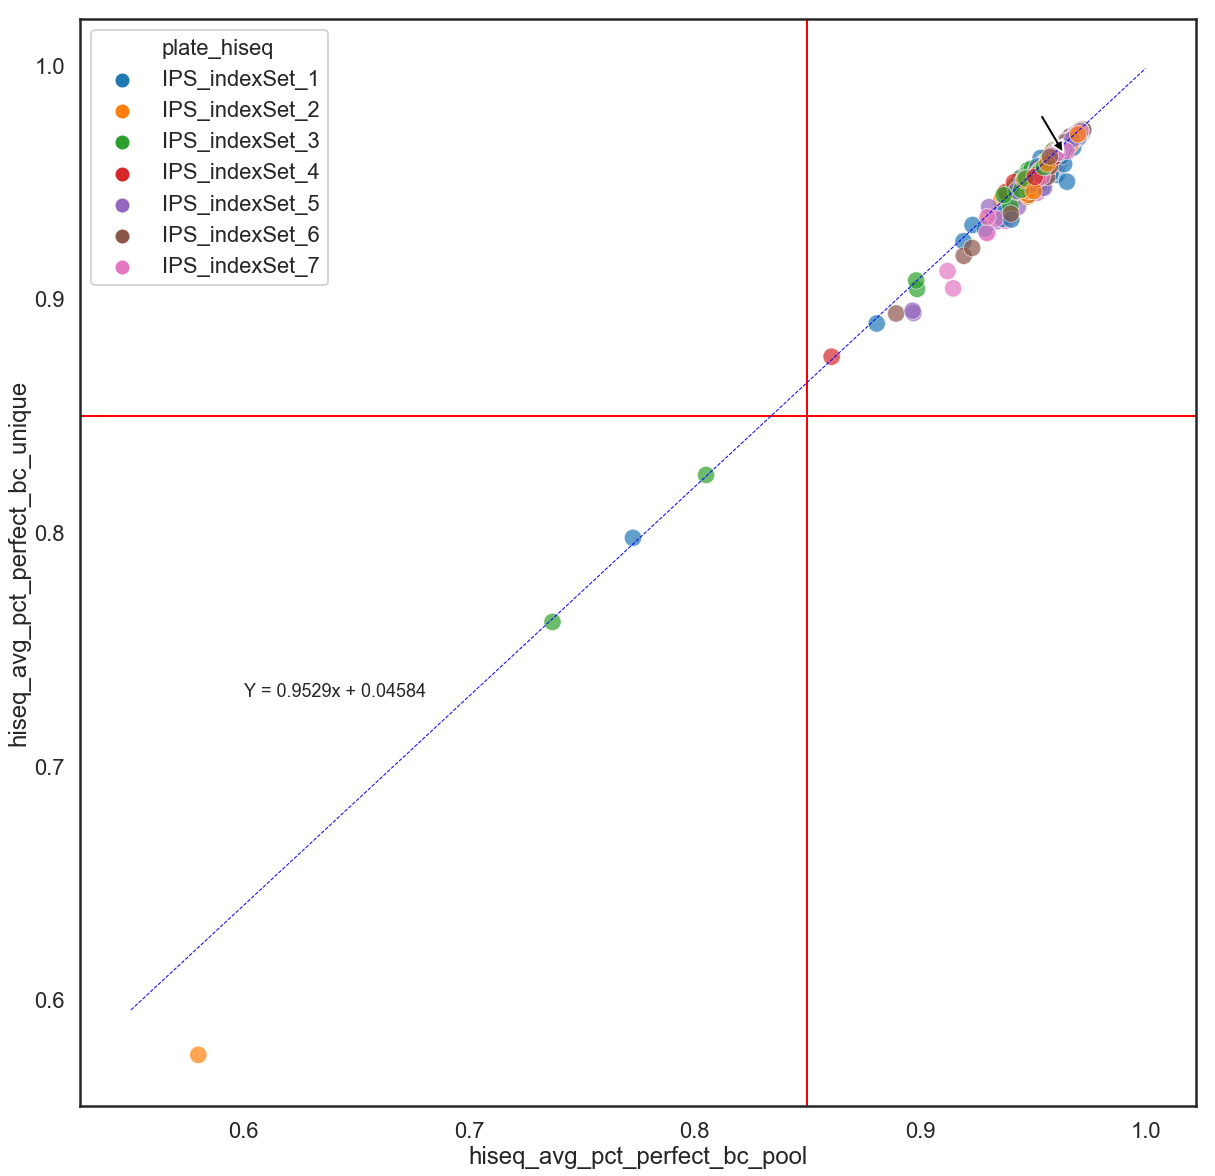

In [33]:
# Scatter plot by barcode comparing hiseq_avg_pct_perfect_bc _pool vs _unique
plate_list=['IPS_indexSet_1', 'IPS_indexSet_2', 'IPS_indexSet_3', 'IPS_indexSet_4', 'IPS_indexSet_5',
           'IPS_indexSet_6', 'IPS_indexSet_7']

df_compare1 = df_compare.copy()
df_compare1['plate_hiseq'] = df_compare['plate_coor_pool'].str[:-4]

#grid lines
sns.set_style("white")
# sns.axes_style('whitegrid', {'axes.grid': True, 'grid.color': '.8', 'grid.linestyle': '.'})

#figure

fig1 = plt.figure(figsize=(20, 20))
scat = fig1.add_subplot(111)
sns.set_context("poster")
scat = sns.scatterplot(data=df_compare1, x='hiseq_avg_pct_perfect_bc_pool', y='hiseq_avg_pct_perfect_bc_unique',
                       hue='plate_hiseq', alpha=.7, s=300, hue_order=plate_list)

#highlight box
# line1 = slope * 20000 + intercept
plt.axvline(.85, color='r', linewidth=2)
plt.axhline(.85, color='r', linewidth=2)

# add arrow for outlier point (ACCATTCG IPS_indexSet_1_B09)
ax = fig1.add_subplot(111)
ax.annotate(' ',xy=(0.9636, 0.9627), #x,y for point
            xytext=(.95, 0.98), #  x, y arrow base
            arrowprops=dict(facecolor='black', shrink=1),
            horizontalalignment='left',
            verticalalignment='bottom',
            clip_on=True)
# 0.9636, 0.9627

# plot trendline
line = bc_slope * 1 + bc_intercept
plt.plot([.55,1],[bc_intercept+0.55,line], 'b--', linewidth=1)

equation = 'Y = ' + str('{0:.4g}'.format(bc_slope)) + 'x + ' + str('{0:.4g}'.format(bc_intercept))
plt.text(0.6,0.73,equation, label='trendline', fontsize=18)



# plt.show()

#save figure
# figure = scat.get_figure()
# figure.savefig("/Users/rchin/Downloads/pool_unique_perfect_bc_6.5_gridarrow.png", bbox_inches = 'tight')



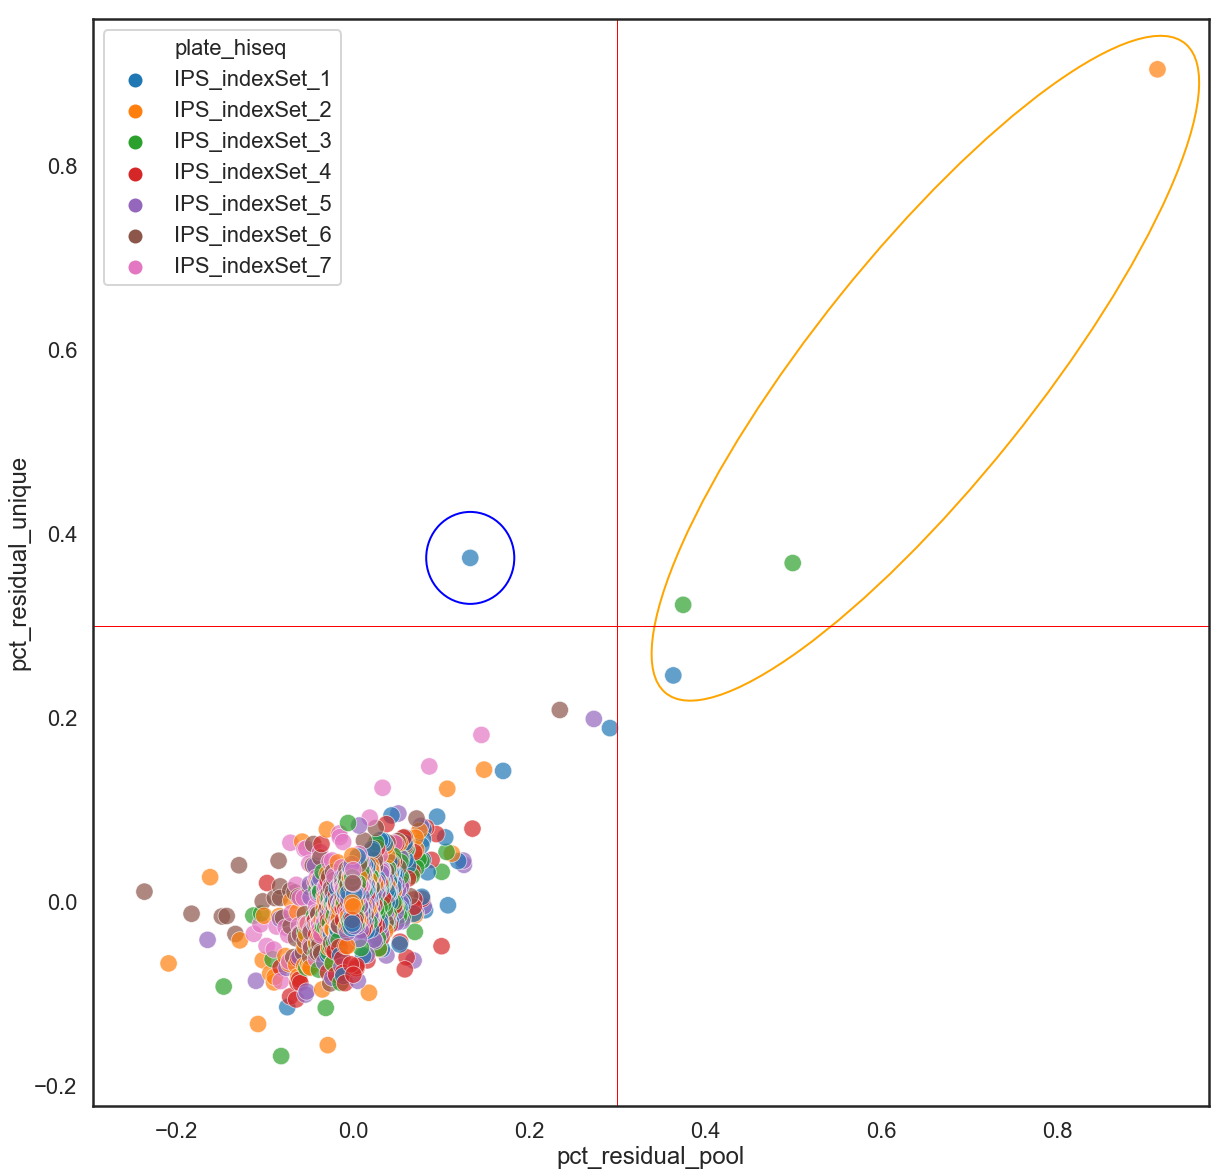

In [34]:
# Scatter plot by barcode comparing pct_residual _pool vs _unique
import matplotlib.patches as patches

plate_list=['IPS_indexSet_1', 'IPS_indexSet_2', 'IPS_indexSet_3', 'IPS_indexSet_4', 'IPS_indexSet_5',
           'IPS_indexSet_6', 'IPS_indexSet_7']

df_compare1 = df_compare.copy()
df_compare1['plate_hiseq'] = df_compare['plate_coor_pool'].str[:-4]

#grid lines
sns.set_style("white")
# sns.axes_style('whitegrid', {'axes.grid': True, 'grid.color': '.8', 'grid.linestyle': '.'})

#figure
fig1 = plt.figure(figsize=(20, 20))
scat = fig1.add_subplot(111)
sns.set_context("poster")
scat = sns.scatterplot(data=df_compare1, x='pct_residual_pool', y='pct_residual_unique',
                       hue='plate_hiseq', alpha=.7, s=300, hue_order=plate_list)

ax = fig1.add_subplot(111)


# axes for thresholds
plt.axvline(.3, color='r', linewidth=1)
plt.axhline(.3, color='r', linewidth=1)
# plt.axvline(0, color='grey', linewidth=2)
# plt.axhline(0, color='grey', linewidth=2)

#add ovals around points of interest
ax.add_patch(
    patches.Circle((0.1333, .3738),           # (x,y)
                   .05,                   # radius
                   alpha=1, fill=False, edgecolor="blue", linewidth=2, linestyle='solid'))
ax.add_patch(patches.Ellipse((0.65, 0.58),
                             0.25, .92,
                              angle=-40, alpha=1, linewidth=2, fill=False, edgecolor='orange'))

# plt.show()

#save figure
# figure = scat.get_figure()
# figure.savefig("/Users/rchin/Downloads/pool_unique_pct_residual_6.5_oval.png", bbox_inches = 'tight')



In [35]:
cv_appb = stats.variation(df_compare.diff_hiseq_avg_pct_perfect_bc.dropna())
cv_pct_resid = stats.variation(df_compare.diff_pct_residual.dropna())

# print('CV Difference Average Percent Perfect Barcode: ', cv_appb)
# print('CV Difference Percent Residual: ', cv_pct_resid)

#cv = std/mean*100
std_appb = (df_compare.diff_hiseq_avg_pct_perfect_bc).std()
mean_appb = (df_compare.diff_hiseq_avg_pct_perfect_bc).mean()
std_pct_resid = (df_compare.diff_pct_residual).std()

# print ('std:',std_appb, '  mean:',mean_appb)
# print (std_appb / mean_appb)
print ('Standard Deviation Different Average Percent Perfect Barcode:', std_appb)
print ('Standard Deviation Different Percent Residual:', std_pct_resid)


# df_compare.diff_hiseq_avg_pct_perfect_bc.tail(10)#.dropna()

Standard Deviation Different Average Percent Perfect Barcode: 0.002885712889449218
Standard Deviation Different Percent Residual: 0.04880687288120464


In [50]:
# get linear regression of mean_hiseq_avg_pct_perfect_bc and mean_pct_residual
# for all barcodes
# df_compare2 = df_compare.dropna(subset=['pct_residual_pool'])

# for worst-# barcode read accuracies
df_compare2 = df_compare.dropna(subset=['pct_residual_pool']).sort_values(by='mean_hiseq_avg_pct_perfect_bc', ascending=True).head(25)

m_slope, m_intercept, m_rvalue, m_pvalue, m_std_err =\
    stats.linregress(df_compare2['mean_hiseq_avg_pct_perfect_bc'], df_compare2['mean_pct_residual'])
print ('residual/perfect barcode trendline:', m_slope,'x +', m_intercept)
print ('residual/perfect barcode r-squared:',m_rvalue**2)

# display(df_compare2)


residual/perfect barcode trendline: -2.3903209787313084 x + 2.2536799827949654
residual/perfect barcode r-squared: 0.9200554035076198


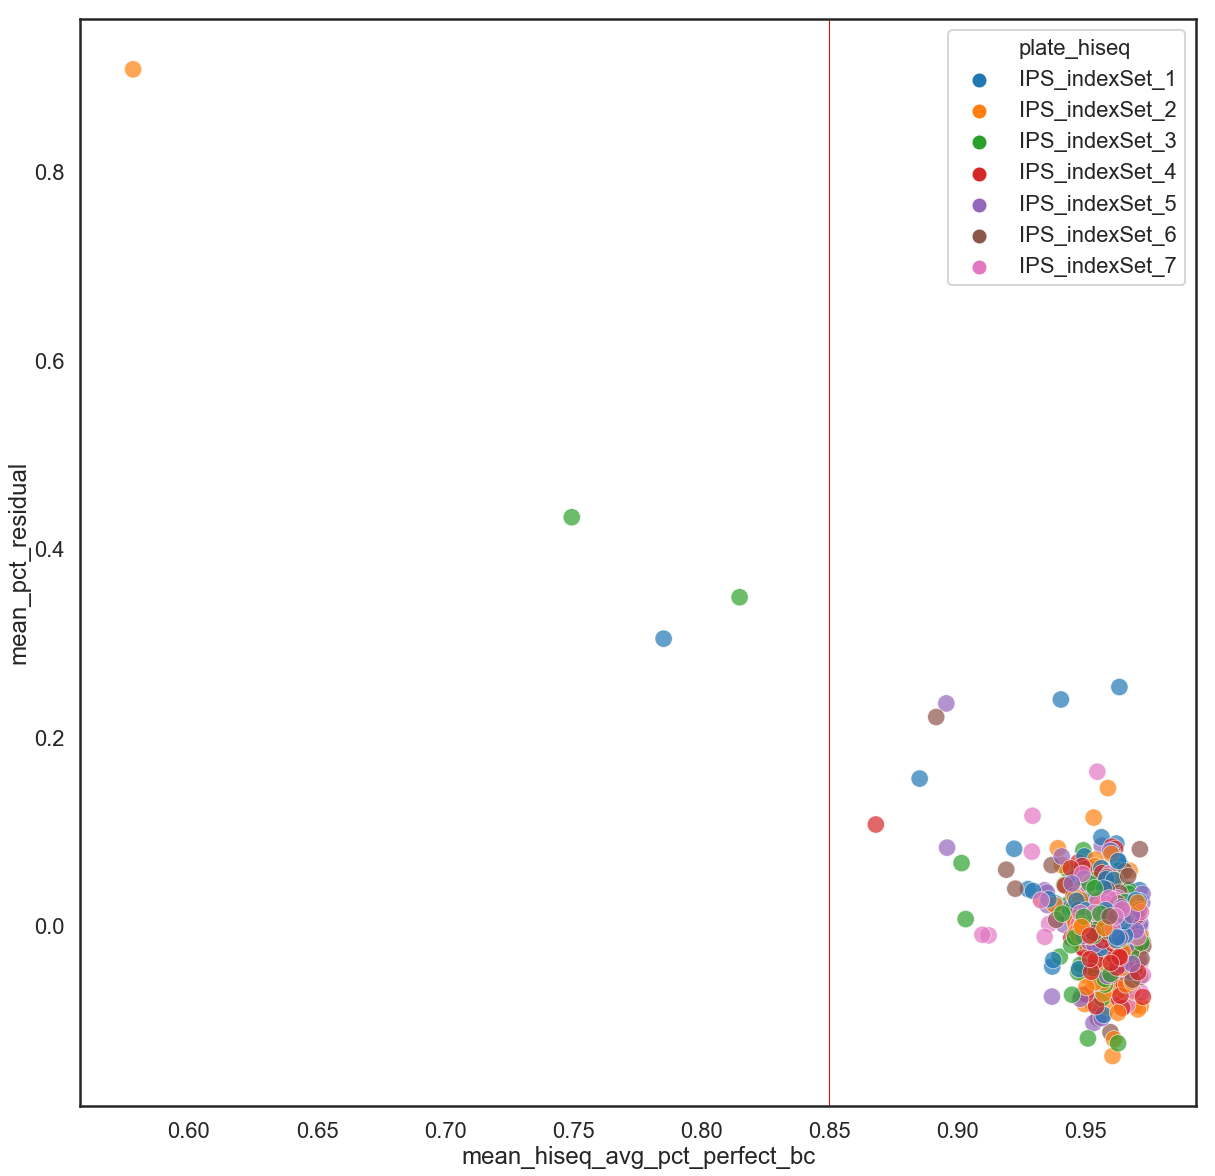

In [52]:
# plot mean_hiseq_avg_pct_perfect_bc vs mean_pct_residual to show relationship

plate_list=['IPS_indexSet_1', 'IPS_indexSet_2', 'IPS_indexSet_3', 'IPS_indexSet_4', 'IPS_indexSet_5',
           'IPS_indexSet_6', 'IPS_indexSet_7']

df_compare1 = df_compare.copy()
df_compare1['plate_hiseq'] = df_compare['plate_coor_pool'].str[:-4]

sns.set_style("white")

#figure
fig1 = plt.figure(figsize=(20, 20))
scat = fig1.add_subplot(111)
sns.set_context("poster")
scat = sns.scatterplot(data=df_compare1, x='mean_hiseq_avg_pct_perfect_bc', y='mean_pct_residual', 
                       hue='plate_hiseq', alpha=.7, s=300, hue_order=plate_list)

ax = fig1.add_subplot(111)


# axes for thresholds
plt.axvline(.85, color='r', linewidth=1)
# plt.axhline(.3, color='r', linewidth=1)

#save figure
# figure = scat.get_figure()
# figure.savefig("/Users/rchin/Downloads/mean_pct_residual_perfect_bc_6.19.png", bbox_inches = 'tight')